In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
    @addConstraint(m, coeffs[1] == 1)  # enforce g(0) = 1
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Apr_weekday_MD.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [10]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 645.706672
  (4,4) => 0.0
  (3,1) => 1631.731326
  (4,5) => 1222.096994
  (2,4) => 1685.678259
  (6,5) => 1183.418117
  (8,4) => 1449.064927
  (1,2) => 0.0
  (5,1) => 7.3e-5
  (3,4) => 0.002464
  (8,2) => 956.88971
  (2,3) => 3.973173
  (2,6) => 4.080324
  (5,4) => 1279.216793
  (2,1) => 627.513303
  (2,5) => 0.002246
  (8,5) => 0.329712
  (1,4) => 0.0
  (2,8) => 3.676639
  (5,8) => 173.205678
  (4,8) => 1654.728567
  (7,8) => 1023.299525
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 229.719282
  ⋮     => ⋮

In [11]:
using JSON

link_day_minute_Apr_dict = readall("../temp_files/link_day_minute_Apr_dict_JSON_adjusted.json");
link_day_minute_Apr_dict = replace(link_day_minute_Apr_dict, "NaN", 0);

link_day_minute_Apr_dict = JSON.parse(link_day_minute_Apr_dict);

In [12]:
# week_day_Apr_list = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30]

# training set 1
week_day_Apr_list_1 = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19]

# training set 2
week_day_Apr_list_2 = [2, 3, 4, 5, 6, 9, 10, 20, 23, 24, 25, 26, 27, 30]

# training set 3
week_day_Apr_list_3 = [11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30]

arcs_1 = Dict{(Int, Int), Arc}[]
for j in week_day_Apr_list_1
    arcs_1_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["MD_flow"]
        arcs_1_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_1, arcs_1_)
end

arcs_2 = Dict{(Int, Int), Arc}[]
for j in week_day_Apr_list_2
    arcs_2_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["MD_flow"]
        arcs_2_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_2, arcs_2_)
end

arcs_3 = Dict{(Int, Int), Arc}[]
for j in week_day_Apr_list_3
    arcs_3_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["MD_flow"]
        arcs_3_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_3, arcs_3_)
end

In [13]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_1); 
sigma = .0

flow_data_1 = Array(Float64, length(arcs_1[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_1[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_1[:, iRun] = [a.flow::Float64 for a in values(arcs_1[iRun])]
end

In [14]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_2); 
sigma = .0

flow_data_2 = Array(Float64, length(arcs_2[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_2[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_2[:, iRun] = [a.flow::Float64 for a in values(arcs_2[iRun])]
end

In [15]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_3); 
sigma = .0

flow_data_3 = Array(Float64, length(arcs_3[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_3[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_3[:, iRun] = [a.flow::Float64 for a in values(arcs_3[iRun])]
end

In [16]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [645.706672,645.706672,645.706672,645.706672,645.706672,645.706672,6…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [1631.731326,1631.731326,1631.731326,1631.731326,1631.731326,1631.73…
  (4,5) => [1222.096994,1222.096994,1222.096994,1222.096994,1222.096994,1222.09…
  (2,4) => [1685.678259,1685.678259,1685.678259,1685.678259,1685.678259,1685.67…
  (6,5) => [1183.418117,1183.418117,1183.418117,1183.418117,1183.418117,1183.41…
  (8,4) => [1449.064927,1449.064927,1449.064927,1449.064927,1449.064927,1449.06…
  (1,2) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (5,1) => [7.3e-5,7.3e-5,7.3e-5,7.3e-5,7.3e-5,7.3e-5,7.3e-5,7.3e-5,7.3e-5,7.3e…
  (3,4) => [0.002464,0.002464,0.002464,0.002464,0.002464,0.002464,0.002464,0.00…
  (8,2) => [956.88971,956.88971,956.88971,956.88971,956.88971,956.88971,956.889…
  (2,3) => [3.973173,3.973173,3.973173,3.973173,3.973173,3.973173,3.973173,3.97

In [17]:
flow_data_3

24x14 Array{Float64,2}:
 4652.65  4376.44  4393.39  3964.61  5109.43  …  4618.67  3695.27  4194.17 
 2322.81  3098.14  2686.33  2086.58  3244.4      2962.39  2157.79  2671.58 
 4105.56  3581.89  3806.9   3359.9   3346.91     3197.37  2880.87  3134.87 
 1618.51  1925.49  1840.3   1976.61  1619.4      1739.1   1167.74  1608.4  
 2671.69  2388.6   1838.39  1483.17  2695.05     2348.24  2049.61  2269.42 
 5313.54  4952.82  4714.21  4375.44  5870.51  …  5551.22  4591.99  5221.65 
 2120.1   2723.42  3178.81  2466.92  2145.13     1464.1   1669.65  1898.93 
 2738.69  3069.68  2830.7   2291.34  3084.32     2504.21  2045.82  2484.19 
 4367.71  4720.33  3485.54  2889.68  4637.3      4685.86  1763.71  4765.55 
 1388.85  1893.37  1754.28  1966.35  1080.9      1248.58  1265.58   897.98 
 4412.78  4404.61  4243.09  3376.59  3889.63  …  3812.39  3980.6   3677.26 
 1408.99  2146.7   1966.96  1688.4   1265.63     1642.08  1313.82   916.038
 4599.52  5155.54  3143.37  2502.36  6059.84     5980.91  2443.0

In [18]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [645.706672,645.706672,645.706672,645.706672,645.706672,645.706672,6…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [1631.731326,1631.731326,1631.731326,1631.731326,1631.731326,1631.73…
  (4,5) => [1222.096994,1222.096994,1222.096994,1222.096994,1222.096994,1222.09…
  (2,4) => [1685.678259,1685.678259,1685.678259,1685.678259,1685.678259,1685.67…
  (6,5) => [1183.418117,1183.418117,1183.418117,1183.418117,1183.418117,1183.41…
  (8,4) => [1449.064927,1449.064927,1449.064927,1449.064927,1449.064927,1449.06…
  (1,2) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (5,1) => [7.3e-5,7.3e-5,7.3e-5,7.3e-5,7.3e-5,7.3e-5,7.3e-5,7.3e-5,7.3e-5,7.3e…
  (3,4) => [0.002464,0.002464,0.002464,0.002464,0.002464,0.002464,0.002464,0.00…
  (8,2) => [956.88971,956.88971,956.88971,956.88971,956.88971,956.88971,956.889…
  (2,3) => [3.973173,3.973173,3.973173,3.973173,3.973173,3.973173,3.973173,3.97

In [19]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    #println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [20]:
#include("trafficCval.jl")

coeffs_dict_Apr_MD = Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}}()

deg_grid = [4:8]
c_grid = .5:.5:3.
lamb_grid = [10. .^(-3:4)]

for deg in deg_grid
    for c in c_grid
        for lam in lamb_grid
            coeffs_dict_Apr_MD[(deg, c, lam, 1)] = train(1:numData, lam, deg, c, demand_data, flow_data_1, arcs_1[1])
            coeffs_dict_Apr_MD[(deg, c, lam, 2)] = train(1:numData, lam, deg, c, demand_data, flow_data_2, arcs_2[1])
            coeffs_dict_Apr_MD[(deg, c, lam, 3)] = train(1:numData, lam, deg, c, demand_data, flow_data_3, arcs_3[1])
        end
    end
end

In [21]:
outfile = open("../temp_files/coeffs_dict_Apr_MD.json", "w")

JSON.print(outfile, coeffs_dict_Apr_MD)

close(outfile)

In [3]:
coeffs_dict_Apr_MD_ = readall("../temp_files/coeffs_dict_Apr_MD.json")
coeffs_dict_Apr_MD_ = JSON.parse(coeffs_dict_Apr_MD_)

Dict{String,Any} with 720 entries:
  "(7,2.5,10000.0,3)" => {1.0,0.026051463396650085,0.017894428996593735,0.00771…
  "(5,0.5,100.0,3)"   => {1.0,0.00912625062217273,0.02372316935292324,0.0261811…
  "(6,1.5,10.0,3)"    => {1.0,0.030025462325061356,0.01394663040549746,0.004225…
  "(6,2.0,0.1,2)"     => {1.0,0.08225431241641364,-0.1463210925136077,0.0736952…
  "(4,0.5,1000.0,1)"  => {1.0,0.012777839604814475,0.020877990086591396,0.01580…
  "(6,2.0,0.01,1)"    => {1.0,0.10665057331388102,-0.27710763484052076,0.287859…
  "(8,1.5,0.01,1)"    => {1.0,0.11971868866145069,-0.3457011773069729,0.3158505…
  "(5,1.5,1.0,1)"     => {1.0,0.04040619694752389,-0.012752658037728907,-0.0096…
  "(8,2.5,0.001,2)"   => {1.0,0.1563368382122256,-0.641079902553213,1.146551091…
  "(4,2.0,0.1,1)"     => {1.0,0.06217175073878225,-0.07492667556367184,0.021955…
  "(5,1.0,1000.0,2)"  => {1.0,0.01645963615887719,0.017844917253089395,0.010399…
  "(4,2.0,0.1,2)"     => {1.0,0.06217175073878225,-0.07492667556367184,0.0

In [4]:
coeffs_dict_Apr_MD_["(8,0.5,100.0,1)"], coeffs_dict_Apr_MD_["(8,0.5,100.0,2)"]

({1.0,-0.003264497841790372,0.05765440308163048,-0.19589087397901542,0.6260724945738348,-0.9155339635885795,0.9446003130763055,-0.47556499258416285,0.1100579620767936},{1.0,-0.003264497841790372,0.05765440308163048,-0.19589087397901542,0.6260724945738348,-0.9155339635885795,0.9446003130763055,-0.47556499258416285,0.1100579620767936})

/home/jzh/.julia/v0.3/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
INFO: Loading help data...


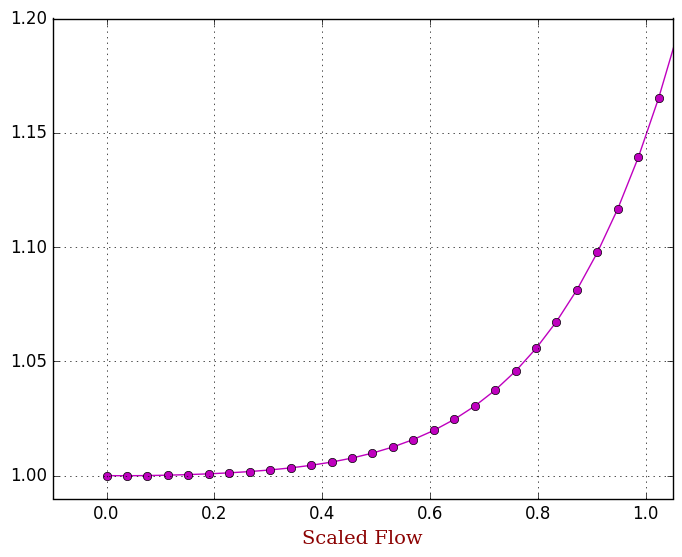

In [5]:
using PyPlot

fcoeffs = coeffs_dict_Apr_MD_["(8,0.5,1000.0,1)"]


xs = linspace(0, 1.1, 30)
ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys, "o-m", label="Apr_MD")

#legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.05);
ylim(0.99, 1.2);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Apr_MD.pdf")